#### Data description
**city:** city this user signed up in

**phone:** primary device for this user

**signup_date:** date of account registration; in the form ‘YYYYMMDD’

**last_trip_date:** the last time this user completed a trip; in the form ‘YYYYMMDD’

**avg_dist:** the average distance in miles per trip taken in the first 30 days after signup

**avg_rating_by_driver:** the rider’s average rating over all of their trips

**avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips

**surge_pct:** the percent of trips taken with surge multiplier > 1

**avg_surge:** The average surge multiplier over all of this user’s trips

**trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up

**ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

**weekday_pct:** the percent of the user’s trips occurring during a weekday

## Part 1 ‐ Exploratory data analysis

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
logins = pd.read_json('logins.json')

In [5]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
# Missing values
logins.isnull().sum()

login_time    0
dtype: int64

**No missing values**

In [9]:
# Duplicates
logins.duplicated().sum()

877

In [10]:
dups = logins.duplicated()
logins[dups]

,login_time
354,1970-01-02 10:59:52
434,1970-01-02 12:27:48
506,1970-01-02 15:08:27
524,1970-01-02 16:14:36
675,1970-01-02 22:03:36
...,...
92051,1970-04-12 05:24:21
92367,1970-04-12 15:46:43
92439,1970-04-12 17:12:21
92986,1970-04-13 12:23:46


In [11]:
duplicates = logins[logins.duplicated(subset=['login_time'], keep=False)]
duplicates

,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
...,...
92439,1970-04-12 17:12:21
92984,1970-04-13 12:23:46
92986,1970-04-13 12:23:46
93021,1970-04-13 13:44:18


In [23]:
dup_percent = (logins.duplicated().sum() / len(logins)) * 100
print(f"Percentage of duplicates: {dup_percent:.2f}%")

Percentage of duplicates: 0.94%


**Since our duplicates are less  <1% I am going to go ahead and drop these duplicates.**

In [26]:
# Drop duplicates, keeping the first occurrence
logins_deduplicated = logins.drop_duplicates(subset=['login_time'], keep='first')

# Verify that duplicates have been removed
print(f"Number of rows after dropping duplicates: {len(logins_deduplicated)}")

Number of rows after dropping duplicates: 92265


In [28]:
# Exploring time range
logins['login_time'].min(), logins['login_time'].max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [30]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


**92,265 entries for only a 4 month period seems to be a lot of logins for a short period of time. I am going to investigate this further.**

#### Aggregate Login Counts into 15-Minute Intervals

In [34]:
# Set the login_time column as the index
logins.set_index('login_time', inplace=True)

# Resample into 15-minute intervals and count logins
login_counts = logins.resample('15T').size()

# Convert the Series back to a DataFrame for easier manipulation
login_counts = login_counts.reset_index()
login_counts.columns = ['login_time', 'login_count']

/var/folders/r0/3ty1gxbn02q24zg2crgysbm40000gn/T/ipykernel_34543/960727455.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  login_counts = logins.resample('15T').size()


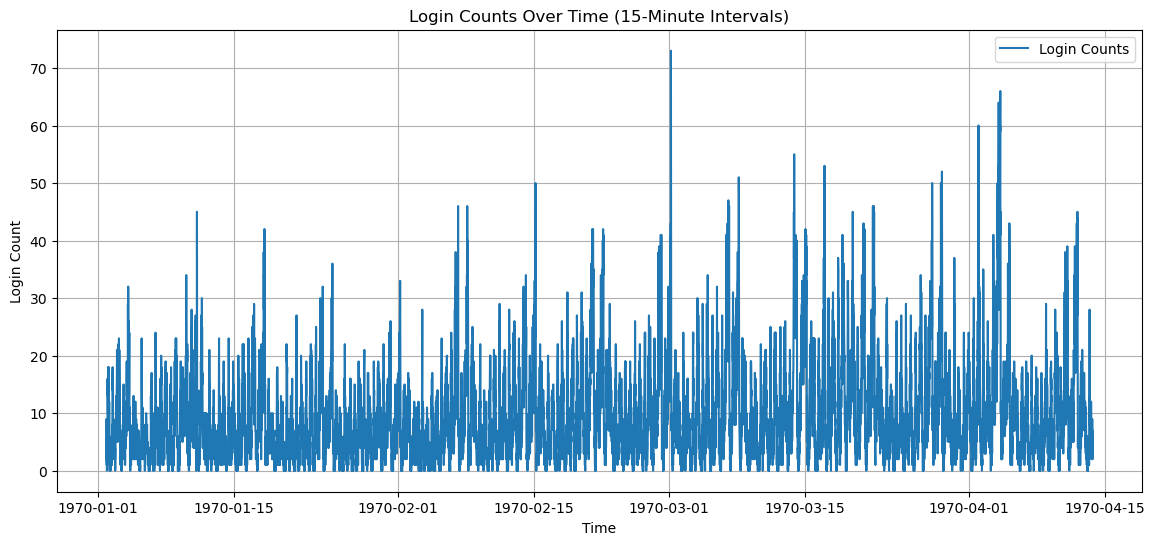

In [36]:
# Visualize
plt.figure(figsize=(14, 6))
plt.plot(login_counts['login_time'], login_counts['login_count'], label='Login Counts')
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.legend()
plt.grid()
plt.show()

**There are some very obvious peaks in our data and troughs. The overall variability increases over time, suggesting perhaps seasonal or cyclic behavior. I am going to check if logins are higher on specific days.**


#### Analyze Daily Cycles

In [42]:
# Extract day of the week from the login_time
login_counts['day_of_week'] = login_counts['login_time'].dt.day_name()

# Group by day of the week and calculate average login counts
daily_avg = login_counts.groupby('day_of_week')['login_count'].mean()

# Reorder days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex(days_order)

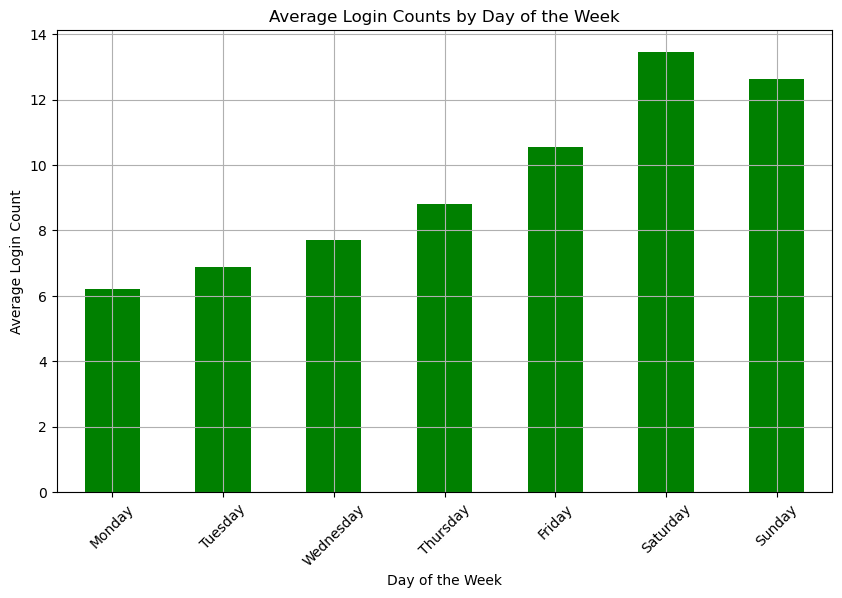

In [46]:
# Visualize daily average login counts
plt.figure(figsize=(10, 6))
daily_avg.plot(kind='bar', color='green')
plt.title('Average Login Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Login Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [50]:
busiest_day = daily_avg.idxmax()
print(f"Busiest day: {busiest_day}")

Busiest day: Saturday


**So the logins trend higher towards the weekend and hit peak on Saturdays**

**Aggregate by Hour of the Day**

In [53]:
# Extract hour from the login_time
login_counts['hour'] = login_counts['login_time'].dt.hour

# Group by hour and calculate average login counts
hourly_avg = login_counts.groupby('hour')['login_count'].mean()

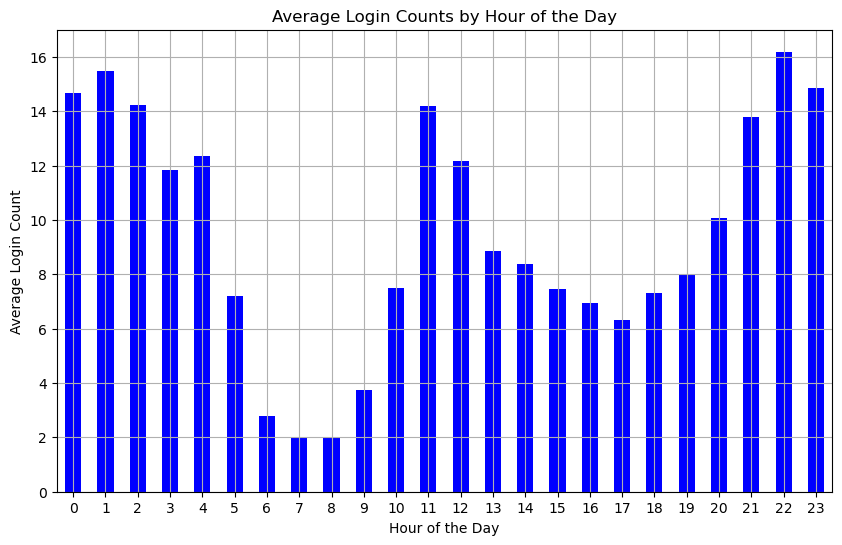

In [57]:
# Visualize hourly average login counts
plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='bar', color='blue')
plt.title('Average Login Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Login Count')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [59]:
# Identify the hour with the highest average login count
peak_hour = hourly_avg.idxmax()
print(f"Peak hour: {peak_hour}:00")

Peak hour: 22:00


### EDA SUMMARY:
Days with Highest Demand: Login activity is highest on Saturdays and Sundays, indicating increased user engagement on weekends.
Peak Hours: Late night & early morning peaks. Significant login activity occurs around midnight to 2 AM and again from 10 PM to midnight.
Midday Activity: There is also a notable spike around 11 AM to 12 PM.
Low Activity Periods: 6 AM - 8 AM sees minimal logins, possibly due to sleep schedules. There is consistent daily and weekly seasonality, where logins surge on weekends and late at night. The time-series graph shows occasional extreme peaks, suggesting sporadic high-traffic events.
Duplicates Removed: 877 duplicate records were identified and removed to ensure data accuracy.
No Missing Data: The dataset was complete, reducing concerns about imputation or bias.
Potential Timestamp Issues: The time-series graph has timestamps from 1970, which may indicate a data processing or system time issue.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**Key Metric for success:** The percentage of driver partners who make trips between both cities before and after the toll reimbursement. This metric directly measures the experiment's goal of increasing driver availability in both cities by tracking cross-city trips, which indicates reduced exclusivity.

**Experiment:**
**Implementation:** A/B Testing- randomly assign drivers into two groups, where the control group receives no reimbursement and the treatment group receives reimbursement for toll costs. Collect baseline data for 2-4 weeks. We may also want to track driver movement between cities, trip counts, and earnings.

**Statistical Test:**
Chi-square test to compare the proportion of drivers serving both cities between the control and treatment groups.

**Interpretation and Recommendations:**
If the treatment group shows a significant increase in cross-city trips, recommend rolling out the reimbursement program.
If no significant change is observed, consider additional incentives (e.g., bonuses for cross-city trips).
Caveats: External factors like weather, gas prices, or special events could influence results. Running the experiment for an extended period can help mitigate short-term variability.